# Front Matter

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import ElasticNetCV

# Load and Process Neural-MADRS Dataset

In [2]:
data = pd.read_csv('PR01-LTFU-Neural_MADRS.csv', header=[0,1], index_col=0)

# Neural Features (predictors)
X = data.drop(columns='MADRS')

# MADRS (outcome variable)
Y = data['MADRS']

# Remove days where neural recordings are not aligned to MADRS.
X_with_madrs = X.loc[~Y.isna().any(axis=1)]
Y_with_madrs = Y.loc[~Y.isna().any(axis=1)]

# Standardize the neural features
X_with_madrs_mu = X_with_madrs.mean(axis=0)
X_with_madrs_sd = X_with_madrs.std(axis=0)
X_with_madrs_zs = ((X_with_madrs - X_with_madrs_mu) / X_with_madrs_sd)
X_zs = ((X - X_with_madrs_mu) / X_with_madrs_sd)

# Train Elastic Net

In [3]:
elastic_net_params = {
    'cv': X_with_madrs_zs.shape[0],    # Leave-one-out
    'l1_ratio': 0.1,                   
    'max_iter': 10000}

model = ElasticNetCV(**elastic_net_params)

model.fit(X_with_madrs_zs, Y_with_madrs)

/userdata/akhambhati/Hoth/Repos/Pkgs/Presidio_Dev/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(cv=451, l1_ratio=0.1, max_iter=10000)

# Model Performance and Permutation Test

In [24]:
n_perm = 10000
R2_true = model.score(X_with_madrs_zs, Y_with_madrs)
R2_null = np.array([model.score(X_with_madrs_zs.sample(frac=1).values, Y_with_madrs)
                    for i in range(n_perm)])
R2_pv = max(np.mean(R2_null >= R2_true), 1/n_perm)

# Model Weights

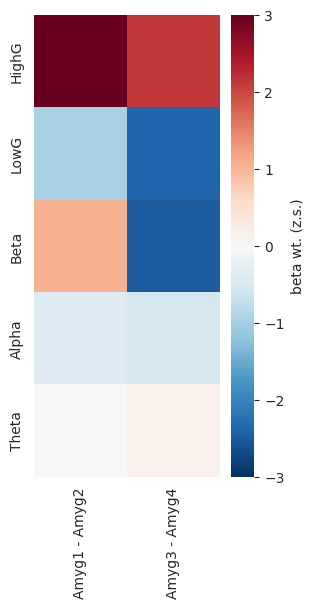

In [25]:
coef = pd.Series(model.coef_, index=X.columns).unstack()
coef = coef[['HighG', 'LowG', 'Beta', 'Alpha', 'Theta']].T

plt.figure(figsize=(3,6), facecolor='white')
sns.heatmap(coef, cmap='RdBu_r', vmin=-3, vmax=3, cbar_kws={'label': 'beta wt. (z.s.)'})
plt.savefig('PR01-MADRS-DecoderWeights.svg')

# Decode daily MADRS from Neural Features

In [7]:
Y_decoded = pd.Series(model.predict(X_zs), index=X_zs.index)

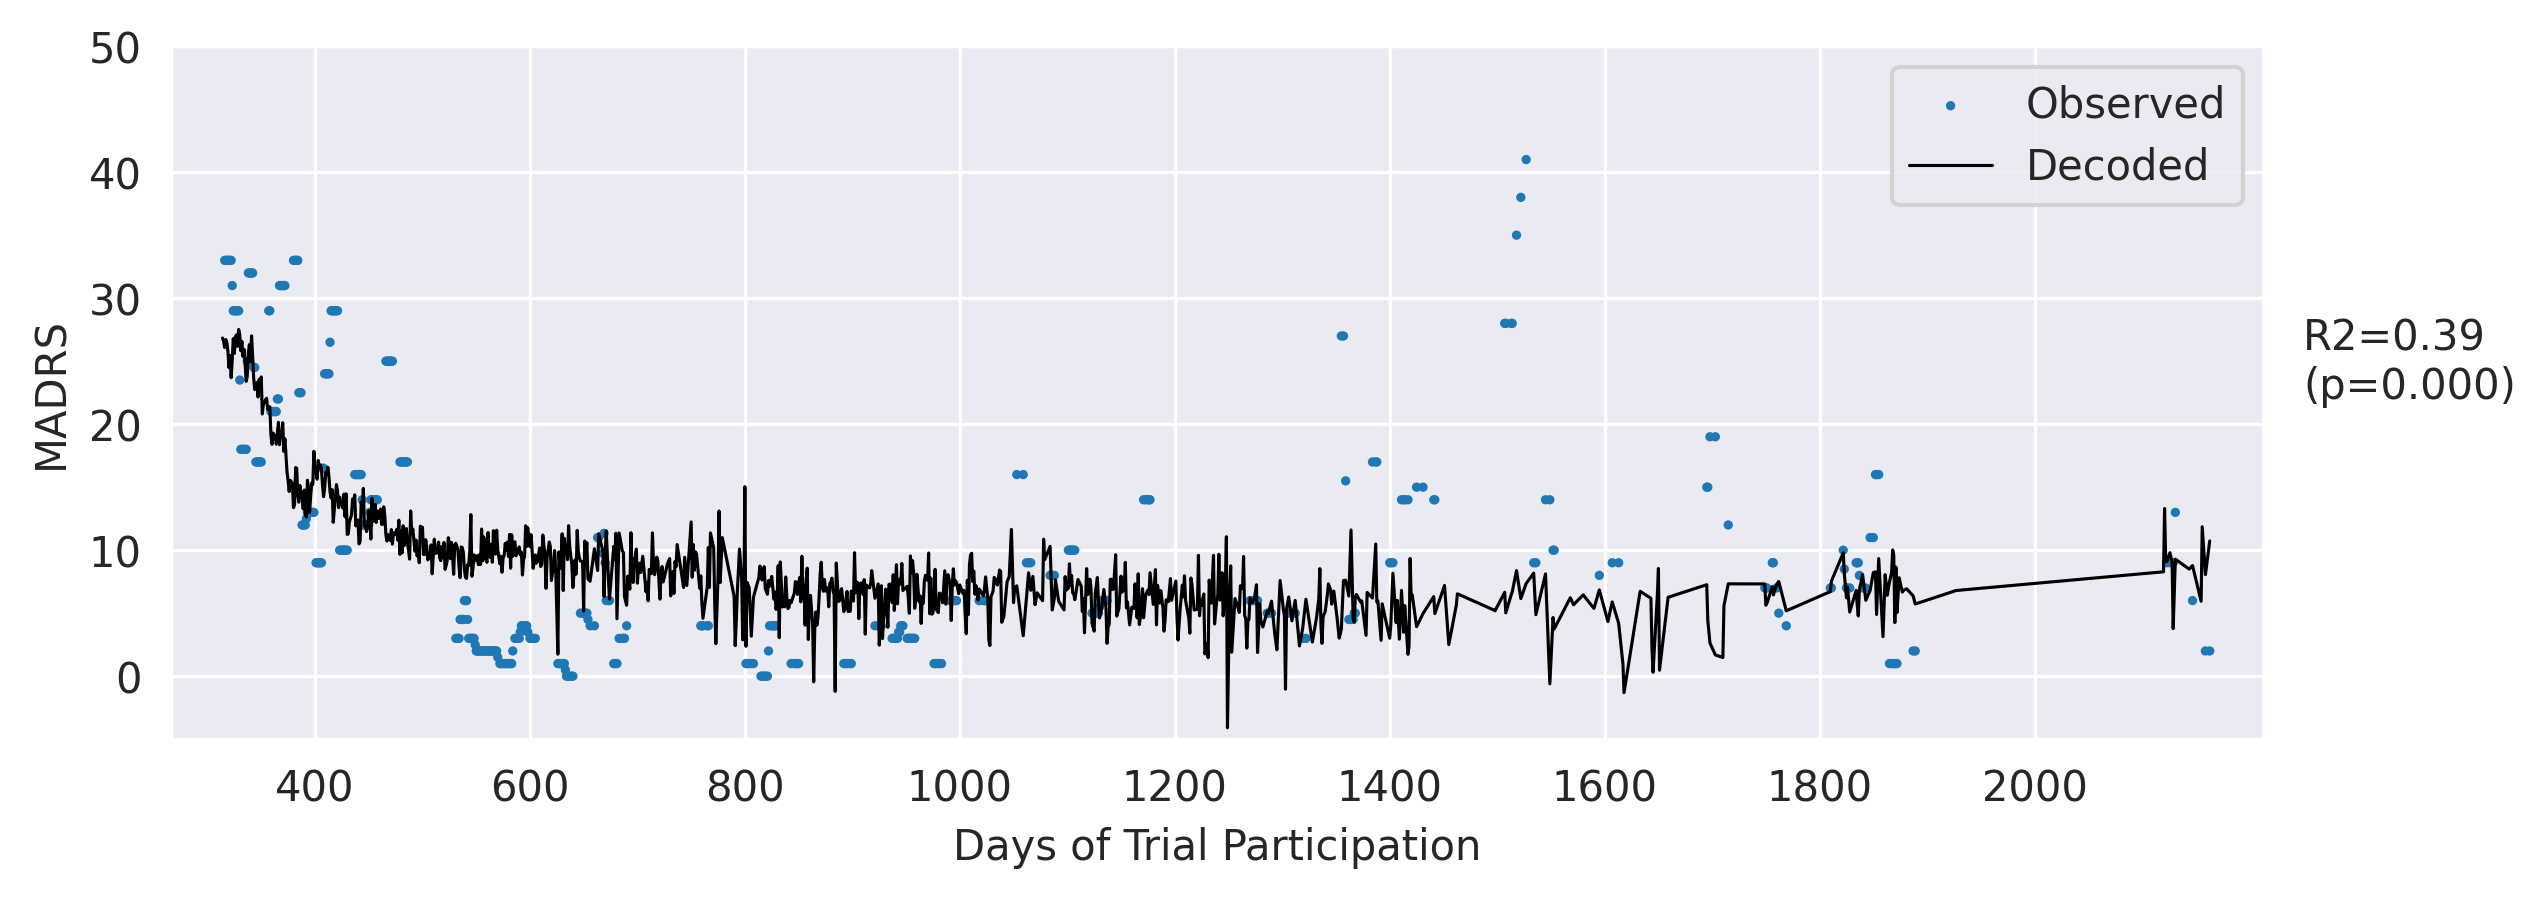

In [26]:
plt.figure(figsize=(9, 3), dpi=300, facecolor='white')
ax = plt.subplot(111)
ax = sns.scatterplot(data=Y[Y.columns[0]], edgecolor='none', s=5, ax=ax)
ax = sns.lineplot(data=Y_decoded, ax=ax, lw=0.75, color='k')
ax.set_ylabel('MADRS')
ax.text(ax.get_xticks()[-2], 22, 'R2={:0.2f}\n(p={:0.3f})'.format(R2_true, R2_pv))
ax.legend(['Observed', 'Decoded'])
ax.set_ylim([-5, 50])
ax.set_xlim([Y_with_madrs.index.min()-50, Y_with_madrs.index.max()+50])
ax.set_xlabel('Days of Trial Participation')
ax.set_xticks(np.arange(400, 2200, 200))
plt.savefig('PR01-MADRS-Decoder.svg')